In [1]:
import time
import copy
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from landlab import RasterModelGrid, imshowhs_grid, imshow_grid
from landlab.components import FlowAccumulator, Space, LinearDiffuser, PriorityFloodFlowRouter
from landlab.io import read_esri_ascii, write_esri_ascii
from landlab.utils import get_watershed_mask

In [2]:
import os
os.getcwd()


'/home/jupyter-sjb00020@mix.wvu.e-c1576/ivy/fire_precip/model'

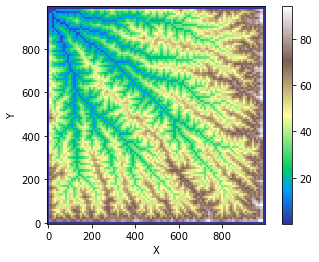

In [3]:
topo = np.loadtxt('fake_topo.txt')

nx = 100
ny = 100
grid_spacing = 10
mg = RasterModelGrid((nx, ny), grid_spacing)

_ = mg.add_field('bedrock__elevation',topo, at = 'node')

z = mg.add_zeros('topographic__elevation', at ='node')

_ = mg.add_zeros('soil__depth',
                 at = 'node')

mg.at_node["soil__depth"][mg.core_nodes] = 2.0


# mg.at_node["bedrock__elevation"][:] = mg.at_node["topographic__elevation"]
mg.at_node['topographic__elevation'][:] = mg.at_node["bedrock__elevation"][:] + mg.at_node["soil__depth"][:]

# mg.set_watershed_boundary_condition(z,return_outlet_id=True)


imshow_grid(mg, 'topographic__elevation', cmap = 'terrain')



In [4]:

def stochastic_fire(fire_radii_mean,fire_radii_stdv,length_of_fire_distribution,total_duration,timestep,fires_per_timestep,grid_x_length,grid_y_length,k_s_initial,k_s_fire):

    import numpy as np
    
    # Generate normal distribution of fire events
    fire_event_distribution = np.random.normal(fire_radii_mean,fire_radii_stdv,length_of_fire_distribution)
    
    #if len(fire_event_distribution[fire_event_distribution <= 0]) > 0: # If any of the fires are less than zero
        
        # Replace the fire lengths less than zero by resampling from the initial distribution above zero
    fire_event_distribution[fire_event_distribution <= 0] = np.random.choice(fire_event_distribution[fire_event_distribution>0],len(fire_event_distribution[fire_event_distribution <= 0]))
    
    
    # Generate initial matrix of k_s values
    C_domain = np.ones((grid_x_length,grid_y_length,int(total_duration/timestep)))*k_s_initial

    # Generate sample grid coordinates
    X_grid = np.arange(0,(grid_x_length))
    Y_grid = np.arange(0,(grid_y_length))

    # Run simulation and generate a k_s value through time
    
    for i in range(0,total_duration): 
        
        #fire_radii_dt = np.random.choice(fire_event_distribution,fires_per_timestep) # Fire events per timestep
        
        for j in range(0,fires_per_timestep): # For each fire
            
            # Randomly select an X and Y location from the grid
            X = np.random.choice(X_grid)
            Y = np.random.choice(Y_grid)
            
            # Put fire are into grid space 
            X_fire_length = np.arange(0,np.ceil(np.random.choice(fire_event_distribution))) + X     
            Y_fire_length  = np.arange(0,np.ceil(np.random.choice(fire_event_distribution))) + Y
    
                # Make sure fire length in X and Y direction does not exceed the model domain
            
            if max(X_fire_length) >= grid_x_length:
                
                temp  = np.where(X_fire_length >= grid_x_length)
                X_fire_length = X_fire_length[0:len(temp[0])]
                
            else: 
                X_fire_length = X_fire_length
                
            if max(Y_fire_length) >= grid_y_length:
                
                temp  = np.where(Y_fire_length >= grid_y_length)
                Y_fire_length = Y_fire_length[0:len(temp[0])]
                
            else: 
                Y_fire_length = Y_fire_length
            
            # Replace fire locations with new k_s
            C_domain[int(X_fire_length[0]):int(X_fire_length[-1]),int(Y_fire_length[0]):int(Y_fire_length[-1]),i] = k_s_fire 
        

    return C_domain

In [5]:
fire_radii_mean = 10
fire_radii_stdv = 5
length_of_fire_distribution = 10000
total_duration = 100 # yrs
timestep = 1 # yr
fires_per_timestep = 5
grid_x_length = nx
grid_y_length = ny
k_s_initial = 0.0001
k_s_fire = 0.001



K_s_fire_values = stochastic_fire(fire_radii_mean,fire_radii_stdv,length_of_fire_distribution,total_duration,timestep,fires_per_timestep,grid_x_length,grid_y_length,k_s_initial,k_s_fire)






In [6]:
stochastic_fire(fire_radii_mean,fire_radii_stdv,length_of_fire_distribution,total_duration,timestep,fires_per_timestep,grid_x_length,grid_y_length,k_s_initial,k_s_fire)

array([[[ 0.0001,  0.0001,  0.0001, ...,  0.0001,  0.0001,  0.0001],
        [ 0.0001,  0.0001,  0.0001, ...,  0.0001,  0.0001,  0.0001],
        [ 0.0001,  0.0001,  0.0001, ...,  0.0001,  0.0001,  0.0001],
        ..., 
        [ 0.0001,  0.0001,  0.0001, ...,  0.0001,  0.0001,  0.0001],
        [ 0.0001,  0.0001,  0.0001, ...,  0.0001,  0.0001,  0.0001],
        [ 0.0001,  0.0001,  0.0001, ...,  0.0001,  0.0001,  0.0001]],

       [[ 0.0001,  0.0001,  0.0001, ...,  0.0001,  0.0001,  0.0001],
        [ 0.0001,  0.0001,  0.0001, ...,  0.0001,  0.0001,  0.0001],
        [ 0.0001,  0.0001,  0.0001, ...,  0.0001,  0.0001,  0.0001],
        ..., 
        [ 0.0001,  0.0001,  0.0001, ...,  0.0001,  0.0001,  0.0001],
        [ 0.0001,  0.0001,  0.0001, ...,  0.0001,  0.0001,  0.0001],
        [ 0.0001,  0.0001,  0.0001, ...,  0.0001,  0.0001,  0.0001]],

       [[ 0.0001,  0.0001,  0.0001, ...,  0.0001,  0.0001,  0.0001],
        [ 0.0001,  0.0001,  0.0001, ...,  0.0001,  0.0001,  0.0001],
  

In [7]:
dt = 1
total_time = 100
loops = int(total_time/dt)
uplift_rate = .0001

ld = LinearDiffuser(
        mg,
        linear_diffusivity=0.0001) #create a variable for the linear diffuser component with a diffusivity value from literature (0.1>K>.0001)

fa = FlowAccumulator(
        mg,
        flow_director = 'D8')

fr = PriorityFloodFlowRouter(mg,
                             flow_metric='D8',
                             suppress_out = True)

space = Space(mg,K_sed = 0.0001,
              K_br = 0.00000001,
              solver = 'basic')#, discharge_field='surface_water__discharge')

In [8]:
# ksp_grid = RasterModelGrid((nx, ny), grid_spacing)
#_ = ksp_grid.add_field('topographic__elevation', K_s_fire_values[:,:,i], at = 'node')

In [9]:
ksp_grid2 = np.zeros((100,100))
ksp_grid2[:] = K_s_fire_values[:,:,0]

In [10]:
#K_s_fire_values[:,:,i]

START landscape evolution
finished year: 0
finished year: 10
finished year: 20
finished year: 30
finished year: 40
finished year: 50
finished year: 60
finished year: 70
finished year: 80
finished year: 90
completed in 4.135963547229767 minutes


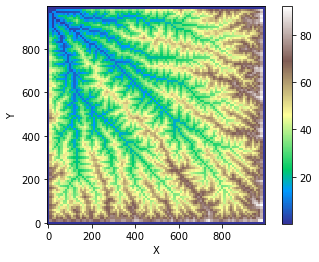

In [11]:
print('START landscape evolution')
t1 = time.time()
for i in range(loops):
    ksp_grid2[:] = K_s_fire_values[:,:,i]
    space = Space(mg,K_sed = ksp_grid2,
              K_br = 0.00001,
              solver = 'basic')
    # stochastic_fire(fire_radii_mean,fire_radii_stdv,length_of_fire_distribution,total_duration,timestep,fires_per_timestep,grid_x_length,grid_y_length,k_s_initial,k_s_fire)
    fa.run_one_step()  #call in the flowaccumulator

    ld.run_one_step(dt) #diffuse the hillslope

    #sp.run_one_step(dt = dt) #call in the main fluvial component
    space.run_one_step(dt)
    #apply uplift
    #mg.at_node['topographic__elevation'][mg.core_nodes] += uplift_rate * dt
    # sed_flux[i] = grid.at_node["sediment__flux"][node_next_to_outlet]
    
    if i%10==0:
        print('finished year: %s' % (i*dt))
        # z_plot_post = mg.node_vector_to_raster(z, flip_vertically = True)
        # sed_flux = mg.at_node['sediment__flux']
        # sed_flux_plot = mg.node_vector_to_raster(sed_flux, flip_vertically = True)
        # fig, (ax, ax1) = plt.subplots(nrows = 1, ncols = 2)
        # im = ax.imshow(z_plot_post, cmap = 'terrain')
        # # plt.colorbar(im, ax = ax)
        # K_s_fire_values[K_s_fire_values[:,:,i] == 0.0001] = None
        # ax.imshow(K_s_fire_values[:,:,i], cmap = 'prism', alpha = 0.35)
        # ax1.imshow(sed_flux_plot, cmap = 'Blues', label = 'sed flux')
        # # plt.colorbar(im, ax = ax1, label = 'sediment flux ($m^3/yr$)')
        # plt.savefig('fire_precip/model/animate/frame'+ str(i) + '.png', dpi = 200)
t2 = time.time()
print('completed in', (t2-t1)/60, 'minutes')

imshow_grid(mg, 'bedrock__elevation', cmap = 'terrain')

<AxesSubplot:xlabel='Easting', ylabel='Northing'>

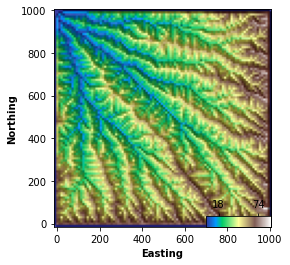

In [21]:
#imshow_grid(mg, 'sediment__flux')
imshowhs_grid(mg, 'bedrock__elevation', cmap = 'terrain')

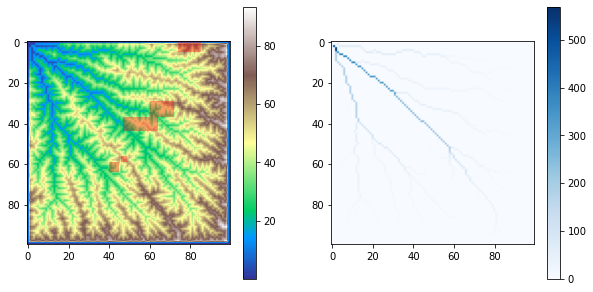

In [22]:

z_plot_post = mg.node_vector_to_raster(z, flip_vertically = True)

sed_flux = mg.at_node['sediment__flux']

sed_flux_plot = mg.node_vector_to_raster(sed_flux, flip_vertically = True)

fig, (ax, ax1) = plt.subplots(nrows = 1, ncols = 2, figsize = (10,5))

im = ax.imshow(z_plot_post, cmap = 'terrain')
# plt.colorbar(im, ax = ax)
K_s_fire_values[K_s_fire_values[:,:,i] == 0.0001] = None

im1 = ax.imshow(K_s_fire_values[:,:,i], cmap = 'prism', alpha = 0.35)

# ax.set_xticks([])
# ax.set_yticks([])

im2 = ax1.imshow(sed_flux_plot, cmap = 'Blues', label = 'sed flux')
fig.colorbar(im, ax = ax)
fig.colorbar(im2, ax = ax1)
# ax1.set_xticks([])
# ax1.set_yticks([])
# plt.colorbar(im, ax = ax1, label = 'sediment flux ($m^3/yr$)')
#plt.savefig('fire_precip/model/animate/frame'+ str(i) + '.png', dpi = 200)
